# Generating catalogs with SkyCatalog

This is a demonstration of using the `SkyCatalog` class to generate catalogs of sky positions over parts of the sky

## Overview

The `SkyCatalogue` class generates a list of RA / DEC coordinates of "dark sky" positions greater than some distance (20 arcsec default) away from any objects brighter than 21 magnitude, using object data from the [Legacy Survey Data Release 10](https://www.legacysurvey.org/dr10/description/) Tractor catalog through querying the [NOIRLAb Astro Data Lab](https://datalab.noirlab.edu/index.php).

## Imports and dependencies

The SkyCatalog class uses functionality from Astropy, Numpy, Pandas, sklearn, matplotlib, and the NOIRLab Astro Data Lab. 

Because of dependency requirements for the Astro Data Lab, it's recommended to use Numpy version 1.26.3 specifically. 

In [1]:
# the jupyter kernel needs to be reset if changes are made to the class
%load_ext autoreload
%autoreload 2

from catalog_class import SkyCatalogue

# these are only necessary for display purposes in this notebook
import matplotlib.pyplot as plt
import numpy as np

## Initialization

First, initialize the object with arguments to describe the properties of the resulting dark sky catalogue:

`bands` *(default = 'g', 'r', 'i','z')*: List of LSDR10 filters used to determine object magnitudes. Possible options include any combination of 'g', 'r', 'i', and 'z'. Note that some objects in the catalog are only detected in certain filters, especially the "reddest" filters, so the combination of filters used can heavily affect the number of dark sky positions generated. These bands can be changed later as keyword arguments into the individual methods as well as needed.

`mag_limit` *(default = 21)*: The limiting magnitude to use when querying the LSDR10 catalog. This must be greater than 16, because objects brighter than 16 magnitude are handled with external mask data that contains no information about the original object magnitude instead of queried tractor data.

`map_dist` *(default = 1 degree)*: The size of one side of the unit-square level analysis during the dark sky identification algorithm. One degree or less is recommended.

`mask_radius` *(default = 20 arcseconds)*: Minimum distance from an object that a "dark sky position" is allowed to occur at. All objects will have masks with a radius of at least `mask_value`.

`fov` *(default = 45 arcseconds)*: Spacing of the grid used to calculate dark positions within the `map_dist` scale analysis, so this is also the minimum spacing between dark sky position coordinates.

This initialization often takes over a minute due to the size of the KDTree object needed for fast distance calculations later on.

In [2]:
catalog = SkyCatalogue()

# for ease of comparison
ra = 3
dec = -4

Initialising...
Initialisation complete!


### Mask data

The files in `mask_data_files/` contain stripped-down versions of the same external mask catalog data used for masking bright/medium stars
(brighter than ABmag 16), galaxies, and clusters in the [legacypipe](https://www.legacysurvey.org/dr10/external/) pipeline for LSDR10. Optionally, the `generate_mask_files.ipynb` notebook can be used to generate mask files yourself, though it requires downloading several GB of the original mask data to do so.

## Generating Dark Sky Positions

For a given starting RA / DEC, there are multiple ways to obtain a catalogue of dark sky positions with `SkyCatalogue`, depending on the desired area of coverage. However, all of the methods follow the same general process:
- Query the Astro Data Lab for objects above `mag_limit` within the area of coverage
- Calculate masking radii for all queried objects based on their brightest magnitude, and combine with the external catalog mask radii.
- Generate a pixel-based segmentation map of the masked objects in a unit square to mark out what areas (pixels) are allowed or forbidden as dark areas.
- Split the segmentation map further into a grid with pre-defined spacing, where the centers of each grid square correspond to an allowed dark sky position if no pixels of a masked object are present within it. The coordinate centers of allowed dark sky positions are then returned as a "catalog" for that square.

### Unit Squares: `SkyCatalogue.create_degree_square()`
The smallest scale of dark sky calculation is with `SkyCatalogue.create_degree_square()`, which is a method only runs the processes described above for a square with a side length of `map_size` defined on initialisation. This method is the smallest and fastest, but may potentially fail to account for nearby bright or extended objects with masks that may overlap into the boundaries of this region of the sky. 

This method can also plot the segmentation map of the associated square of the sky that was queried (`plot_image=True`), and requires the `add_query` flag if ran in isolation.

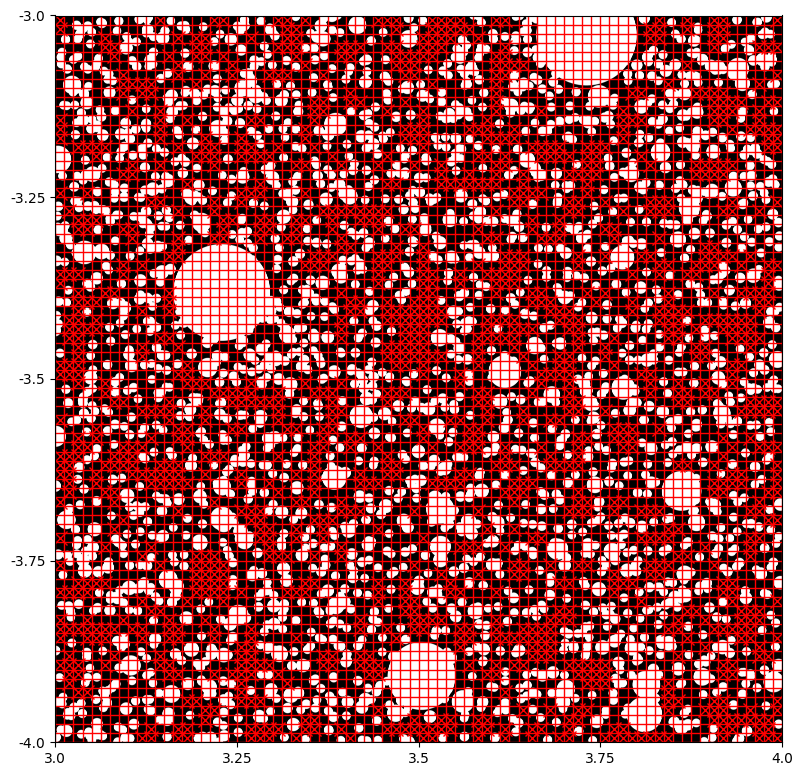

Positions found: 2614


In [43]:

single_degree_corner, overlap = catalog.create_degree_square(ra, dec, plot_image=True, add_query=True)
print(f"Positions found: {single_degree_corner.size}")

The `mode` parameter controls whether the `ra` and `dec` refer to the bottom left corner of the unit square, or to the center. All of the methods in `SkyCatalogue` use the `corner` mode by default (and when stitching multiple squares across the sky), but the `centre` option is available when desired.

>> Querying the tractor catalog for stars from RA/DEC(29.75, 3.75) to (30.25, 4.25)...
>>>> Combining mask and queried stars...
>>>> Calculating pixel values for stars....
>>>> Creating segmentation map...
>>>> Finding dark regions in segmentation map...
>>>> Plotting dark regions...


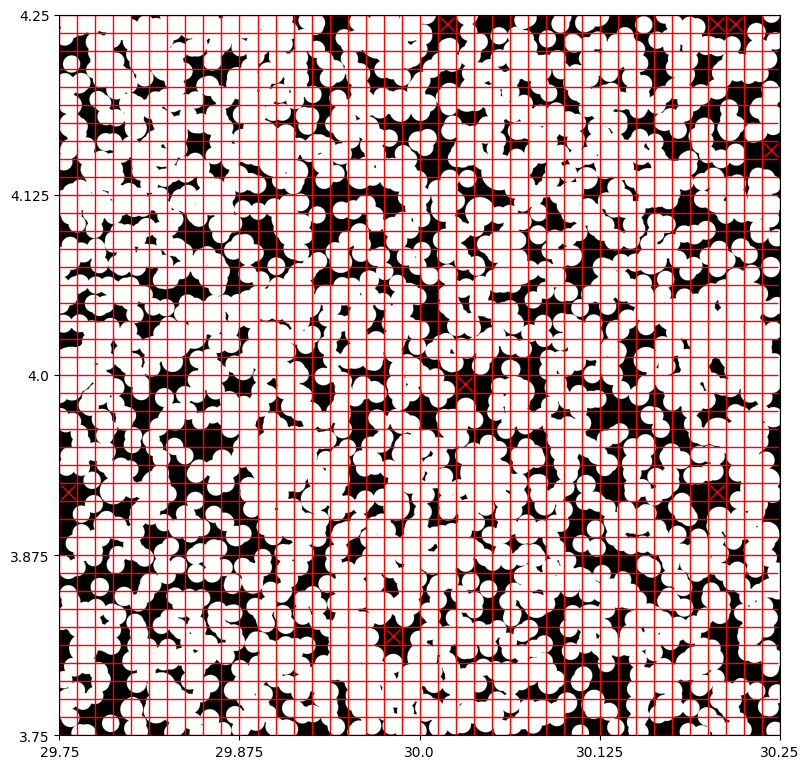

>>>> Converting dark regions to coordinates...
>>>> Finding maximum extent of stars beyond the degree-square bounds...
>>>> Done!
Positions found: 16


In [12]:
single_degree_centre, overlap = catalog.create_degree_square(ra, dec, plot_image=True, add_query=True, mode='centre')
print(f"Positions found: {single_degree_centre.size}")

[2.984696008407812, -4.008426710894652, 4.009241896688543, -2.958397070947133]


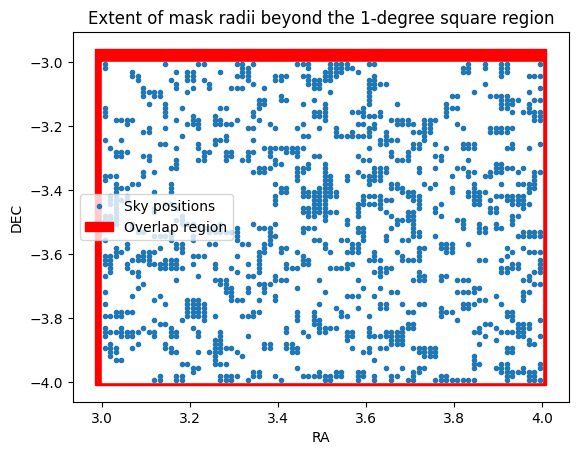

In [44]:
print(overlap)
fig, ax = plt.subplots()
ax.plot(single_degree_corner['ra'], single_degree_corner['dec'], '.', label='Sky positions')

box1 = plt.Rectangle((ra, dec), 1, 1, color='white')
box2 = plt.Rectangle((overlap[0], overlap[1]), overlap[2]-overlap[0], overlap[3]-overlap[1], color='r', label='Overlap region')
ax.add_patch(box2)
ax.add_patch(box1)

ax.legend(loc="center left")
ax.set(title="Extent of mask radii beyond the 1-degree square region", xlabel="RA", ylabel="DEC")
plt.show()

Sky positions can be generated on multiple different levels:
- Single degree (1 x 1) squares using an externally provided dataframe of star ra/dec and mask radius to work from
- Single query (n x n degree) square split up into single-degree chunks
- "Full sky" split up into (n x n degree) square queries, with each of those also split into single-degree chunks

### Single-query squares: `SkyCatalogue.create_catalogue()`

For areas of the sky greater than `map_size`, the `create_catalogue()` method queries for objects in the entire area, then calculates positions from multiple unit-square segementation maps within that larger area. Object masks that overlap the unit-square boundaries are used to remove any sky positions in bordering unit-squares that fall between the square's border and the greatest extent of the overlapped masks. 

Sky squares with a `query_dist` > 5 are not recommended, unless you are willing to be patient.

In [ ]:
# multiple degrees
# 2x2 degree query square with all bands (griz) = 73.34 s
# this finds 218 dark sky positions in that area
positions_allbands = catalog.create_catalogue(209, 18, 2, bands=('g'), mode='corner')
print(f"Positions found: {positions_allbands.size}")

> Creating sky catalog from one 2-degree square starting from (209, 2) to (211, 4)
Positions found: 4446


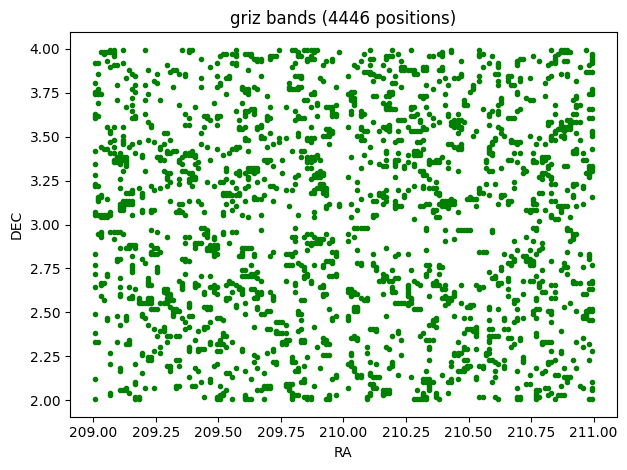

In [23]:
fig, ax = plt.subplots()
ax.plot(positions_allbands['ra'], positions_allbands['dec'], 'g.')
ax.set(title=f"griz bands ({positions_allbands.size} positions)", xlabel="RA", ylabel="DEC")
plt.tight_layout()
plt.show()

### Multi-query squares: `SkyCatalogue.all_sky()`
The `all_sky()` method is recommended for large areas of the sky. Similar to how the `create_catalogue()` method stitches together unit-degree squares and accounts for overlap, this method does the same on the query level. 

Large query distances are not recommended, and behavior at the boundaries of RA 0 and 360 / DEC -90 and 30 have not been tested in `centre` mode. 



In [3]:
# generate sections of the whole sky
positions_allsky_griband = catalog.all_sky(ra_allsky=212, dec_allsky=18, sky_dist=4, query_dist=2.0, bands=('g', 'r', 'i', 'z'), mode='corner')

================= WHOLE SKY =================
===== From (212, 18) to (216, 22) in 2 2.0^2 squares ======
===== Bands used: ('g', 'r', 'i', 'z') =====
====== WHOLE SKY: Looping through sky coordinates... =====
====== 2.0-degree square starting from RA,DEC = 212.0, 18.0 ======
> Creating sky catalog from one 2.0-degree square starting from (212.0, 18.0) to (214.0, 20.0)
====== 2.0-degree square starting from RA,DEC = 214.0, 18.0 ======
> Creating sky catalog from one 2.0-degree square starting from (214.0, 18.0) to (216.0, 20.0)
====== 2.0-degree square starting from RA,DEC = 212.0, 20.0 ======
> Creating sky catalog from one 2.0-degree square starting from (212.0, 20.0) to (214.0, 22.0)
====== 2.0-degree square starting from RA,DEC = 214.0, 20.0 ======
> Creating sky catalog from one 2.0-degree square starting from (214.0, 20.0) to (216.0, 22.0)
====== WHOLE SKY: Removing positions from overlapping regions... ======
================= WHOLE SKY: Done! =================
===== WHOLE SKY: 

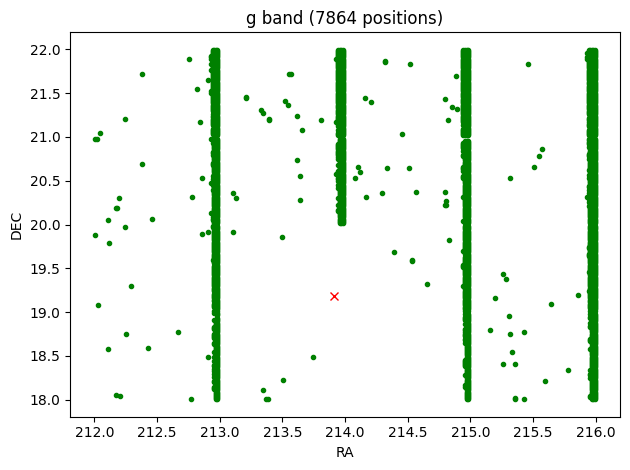

In [4]:
fig, ax = plt.subplots()
ax.plot(positions_allsky_griband['ra'], positions_allsky_griband['dec'], 'g.')
ax.plot(213.9154167,19.1822222, 'rx')
ax.set(title=f"g band ({positions_allsky_griband.size} positions)", xlabel="RA", ylabel="DEC")
plt.tight_layout()
plt.show()

#### Complete sky coverage
This method is (theoretically) capable of generating positions across the entire southern sky (from RA 0 to 360, and DEC -90 to 30) if `full_sky = True`, though this behaviour has not been tested so use at your own risk! Additionally, the functions that account for overlaps between sky regions have not been implemented on the crossover between RA 0 to 360. 

In [9]:
# generate "whole sky"
# positions_allsky = catalog.all_sky(query_dist=2.0, full_sky=True)

## Quirks and other information

### Band choices
Due to the method of source extraction used to make the LSDR10 Tractor catalogue, using different combinations of filters with `SkyCatalogue` will result in drastic differences in sky coordinate density and coverage. The Tractor conducts source extraction from the reddest band first (z), and then progressively in shorter wavelengths with a 6$\sigma$ detection limit that may not keep detections in the other filters [1](https://www.legacysurvey.org/dr10/description/#source-detection), so objects present in one band may not have measurements in another. 

Regardless of the bands chosen, `SkyCatalogue` will use an object's lowest magnitude observation from the available queried bands to calculate its masking radius. 

In [10]:
# 2x2 degree query square with just g band = 37.66 s
# this finds 9716 dark sky positions in that area
positions_gband = catalog.create_catalogue(ra, dec, 2, bands=('g'))
positions_grbands = catalog.create_catalogue(ra, dec, 2, bands=('g', 'r'))
positions_gribands = catalog.create_catalogue(ra, dec, 2, bands=('g', 'r', 'i'))

> Creating sky catalog from one 2-degree square starting from (3, -4) to (5, -2)
>> Querying the tractor catalog for stars from RA/DEC(3, -4) to (5, -2)...
>> Looping through sky coordinates...
>>> Generating sky catalog for square RA,DEC (3.0, -4.0) to (3.5, -3.5)...
>>>> Combining mask and queried stars...
>>>> Calculating pixel values for stars....
>>>> Creating segmentation map...
>>>> Finding dark regions in segmentation map...
>>>> Converting dark regions to coordinates...
>>>> Finding maximum extent of stars beyond the degree-square bounds...
>>>> Done!
>>> Generating sky catalog for square RA,DEC (3.5, -4.0) to (4.0, -3.5)...
>>>> Combining mask and queried stars...
>>>> Calculating pixel values for stars....
>>>> Creating segmentation map...
>>>> Finding dark regions in segmentation map...
>>>> Converting dark regions to coordinates...
>>>> Finding maximum extent of stars beyond the degree-square bounds...
>>>> Done!
>>> Generating sky catalog for square RA,DEC (4.0, -4.0) to 

Positions found (griz): 290
Positions found (gri): 846
Positions found (gr): 3074
Positions found (g): 11886


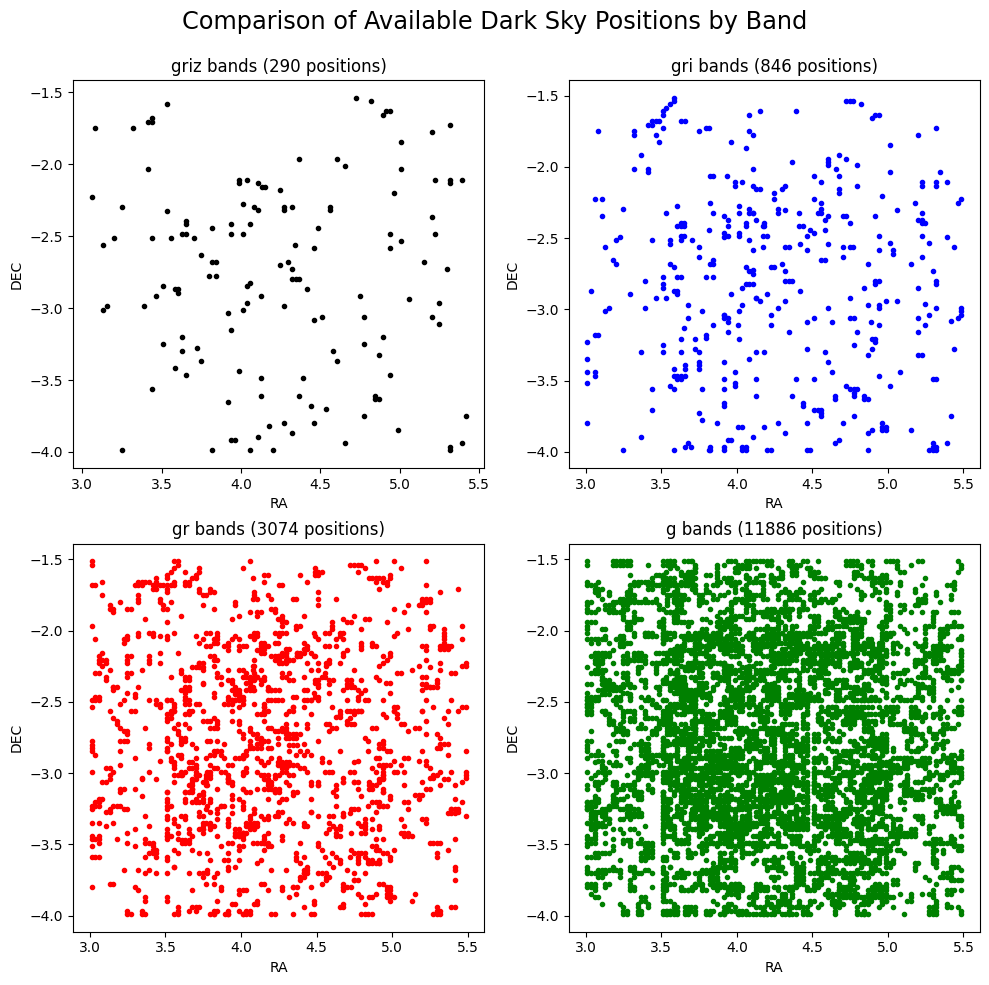

In [20]:
# difference between griz and g band in the same area
print(f"Positions found (griz): {positions_allbands.size}")
print(f"Positions found (gri): {positions_gribands.size}")
print(f"Positions found (gr): {positions_grbands.size}")
print(f"Positions found (g): {positions_gband.size}")

fig, ax = plt.subplots(2, 2, figsize=(10,10))

ax[0,0].plot(positions_allbands['ra'], positions_allbands['dec'], 'k.')
ax[0,0].set(title=f"griz bands ({positions_allbands.size} positions)", xlabel="RA", ylabel="DEC")

ax[0,1].plot(positions_gribands['ra'], positions_gribands['dec'], 'b.')
ax[0,1].set(title=f"gri bands ({positions_gribands.size} positions)", xlabel="RA", ylabel="DEC")

ax[1,0].plot(positions_grbands['ra'], positions_grbands['dec'], 'r.')
ax[1,0].set(title=f"gr bands ({positions_grbands.size} positions)", xlabel="RA", ylabel="DEC")

ax[1,1].plot(positions_gband['ra'], positions_gband['dec'], 'g.')
ax[1,1].set(title=f"g bands ({positions_gband.size} positions)", xlabel="RA", ylabel="DEC")

fig.tight_layout()
fig.suptitle("Comparison of Available Dark Sky Positions by Band", fontsize='xx-large')
fig.subplots_adjust(top=0.91)

plt.show()

#### Characteristic Distances
Band choice causes a drastic difference in the density and number of available dark sky positions, but a Monte Carlo simulation of random positions within the desired range of the sky shows that even with all four filters, the average distance from any place in that square to any dark sky position is on the order of arcminutes. 

In [21]:
from sklearn.neighbors import KDTree

# generate random list of (ra, dec) positions within the bounds of that square
random_ra = np.random.uniform(ra, ra+2, size=10000)
random_dec = np.random.uniform(dec, dec+2, size=10000)

# find closest point to that ra/dec pair
points = np.asarray([random_ra, random_dec]).T
griz_tree = KDTree(np.asarray([positions_allbands['ra'], positions_allbands['dec']]).T)
gri_tree = KDTree(np.asarray([positions_gribands['ra'], positions_gribands['dec']]).T)
gr_tree = KDTree(np.asarray([positions_grbands['ra'], positions_grbands['dec']]).T)
g_tree = KDTree(np.asarray([positions_gband['ra'], positions_gband['dec']]).T)

griz_dist, griz_nearest = griz_tree.query(points, 1, return_distance=True)
gri_dist, gri_nearest = gri_tree.query(points, 1, return_distance=True)
gr_dist, gr_nearest = gr_tree.query(points, 1, return_distance=True)
g_dist, g_nearest = g_tree.query(points, 1, return_distance=True)

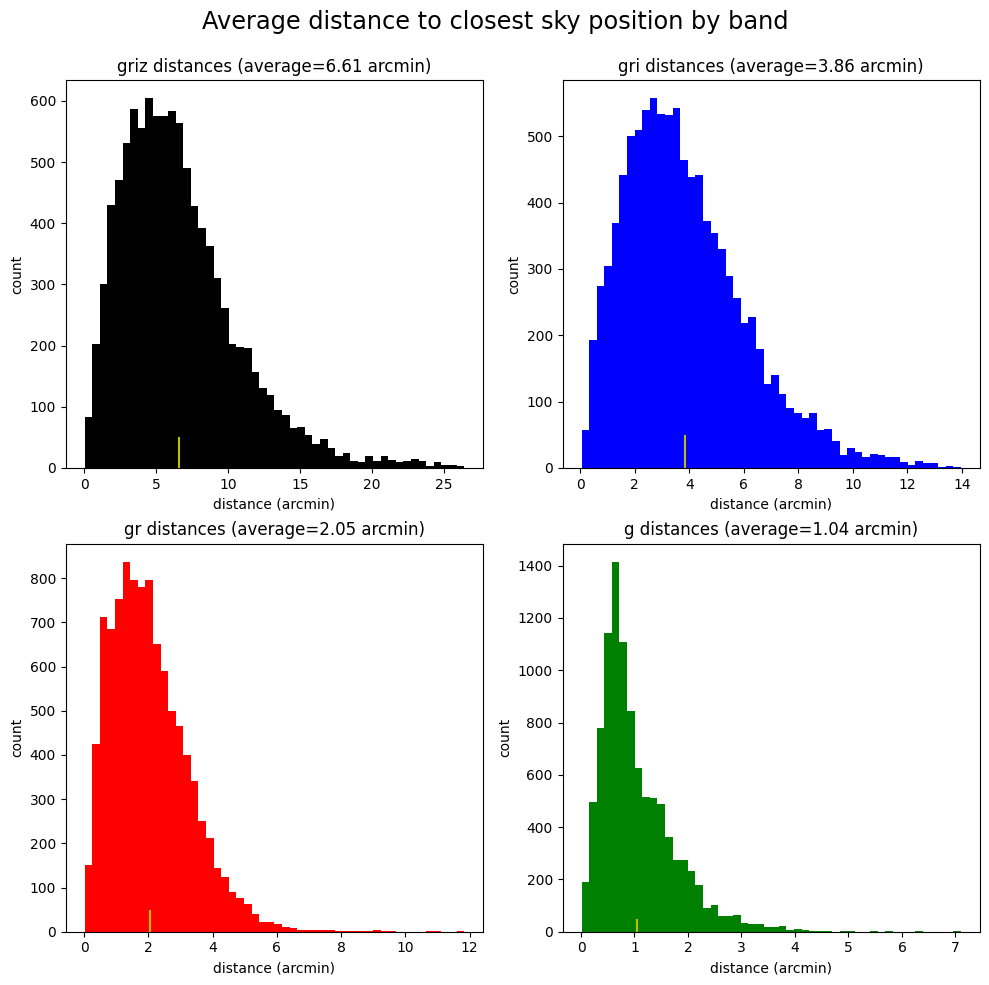

In [22]:
griz_avg = np.average(griz_dist)*60
gri_avg = np.average(gri_dist)*60
gr_avg = np.average(gr_dist)*60
g_avg = np.average(g_dist)*60


fig, ax = plt.subplots(2, 2, figsize=(10,10))

ax[0,0].hist(griz_dist*60, bins=50, color='k')
ax[0,0].vlines(griz_avg, ymin=0, ymax=50, color='y')
ax[0,0].set(title=f"griz distances (average={griz_avg:.2f} arcmin)", xlabel="distance (arcmin)", ylabel="count")

ax[0,1].hist(gri_dist*60, bins=50, color='b')
ax[0,1].vlines(gri_avg, ymin=0, ymax=50, color='y')
ax[0,1].set(title=f"gri distances (average={gri_avg:.2f} arcmin)", xlabel="distance (arcmin)", ylabel="count")

ax[1,0].hist(gr_dist*60, bins=50, color='r')
ax[1,0].vlines(gr_avg, ymin=0, ymax=50, color='y')
ax[1,0].set(title=f"gr distances (average={gr_avg:.2f} arcmin)", xlabel="distance (arcmin)", ylabel="count")

ax[1,1].hist(g_dist*60, bins=50, color='g')
ax[1,1].vlines(g_avg, ymin=0, ymax=50, color='y')
ax[1,1].set(title=f"g distances (average={g_avg:.2f} arcmin)", xlabel="distance (arcmin)", ylabel="count")

fig.tight_layout()
fig.suptitle("Average distance to closest sky position by band", fontsize='xx-large')
fig.subplots_adjust(top=0.91)
plt.show()

### Forbidden regions

The LSDR10 catalogue excludes certain regions of the sky, most notably the Galactic plane (|b| < 18) and Magellanic Clouds [2](https://datalab.noirlab.edu/ls/ls.php). 

Similarly, `SkyCatalogue` will not analyze unit squares that intersect with the range |b| < 19 or rectangles of RA/DEC that fall within explicitly forbidden areas:
- LMC: Between RA (76 to 86) and DEC (-76 to -64)
- SMC: Between RA (11 to 16) and DEC (-76 to -70)
- Gap in LS data near Galactic plane but outside |b| < 19: Between RA (43 to 75) and DEC (10 to 30)

This check is not performed when running the unit-square algorithm in isolation.

Due to the catalogue-based implementation, there is no guarantee that generated positions actually have dark sky behind them, as the `SkyCatalogue` cannot tell if the unmasked space is due to a gap in the source data. 

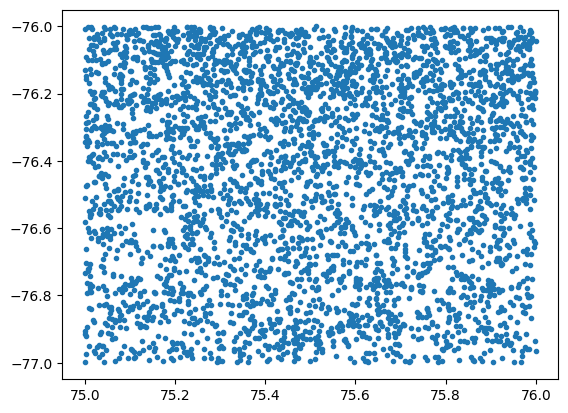

In [ ]:
# query_df = catalog.query_tractor(75, -77)
# plt.plot(query_df['ra'], query_df['dec'], '.')

>> Querying the tractor catalog for stars from RA/DEC(75, -77) to (75.5, -76.5)...
>>>> Combining mask and queried stars...
>>>> Calculating pixel values for stars....
>>>> Creating segmentation map...
>>>> Finding dark regions in segmentation map...
>>>> Plotting dark regions...


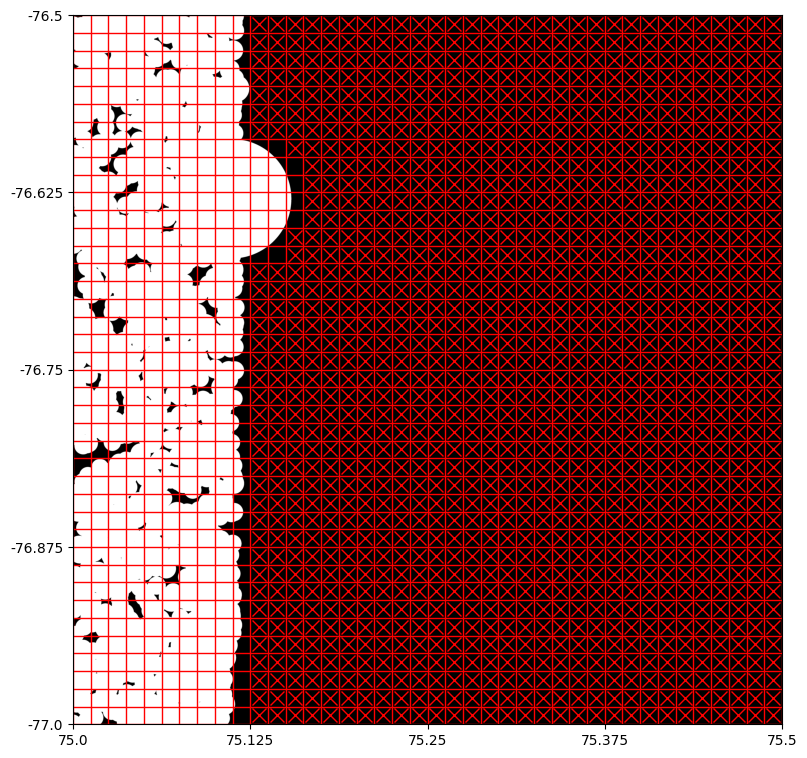

>>>> Converting dark regions to coordinates...


ValueError: too many values to unpack (expected 2)

In [ ]:
# example of squares near b < 19
# near_mw = catalog.create_catalogue(ra=75, dec=-77, query_dist=2, mode='corner', bands=('r'), plot_image=True)
# near_mw, overlap = catalog.create_degree_square(75, -77, add_query=True, plot_image=True)
# print(f"griz bands ({near_mw.size} positions)")

In [ ]:
# ra, dec = 75, -77
# coords = [ra, ra+0.5, dec, dec+0.5]
# query = catalog.query_tractor(ra, dec, 0.5)
# all_stars = catalog.combine_data(query, coords)
# all_stars, w = catalog.create_pixel_columns(all_stars, coords)
# segmap = catalog.seg_map(all_stars)
# dr_trans, dark_regions = catalog.find_dark_regions(segmap)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 75.0  -77.0  
CRPIX : 0.0  0.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -6.9444444444444e-05  6.94444444444444e-05  
NAXIS : 7200  7200


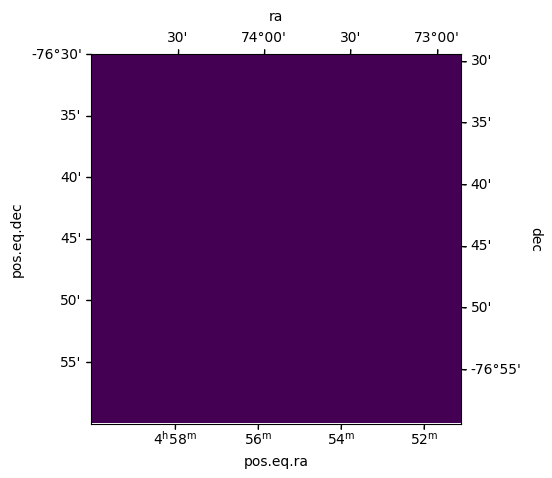

In [ ]:
# # ra should be from: 75 to 75.5 (wrong! this is getting changed to 75,75.5 to 75,77...)
# # dec should be from: -77 to -76.5 (all good)
# fig = plt.figure()
# ax = plt.subplot(projection=w)
# ax.imshow(array)
# # ax.plot(pixarrays[0], pixarrays[1], '.')
# # ax.plot(all_stars['ra'], all_stars['dec'], '.')
# overlay = ax.get_coords_overlay('fk5')
# w.printwcs()
# plt.show()

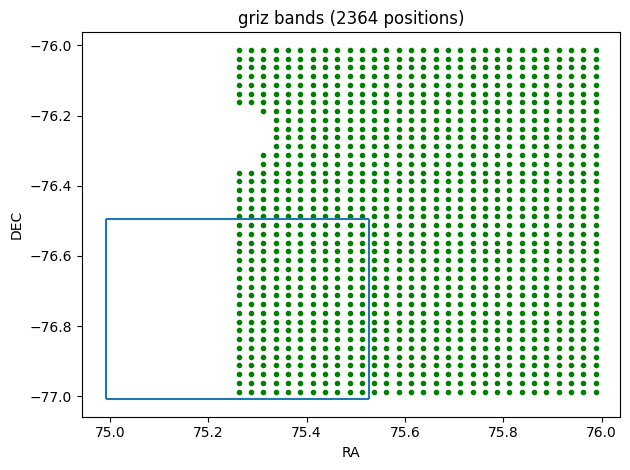

In [ ]:
# # add figure
# fig, ax = plt.subplots()
# ax.plot(near_mw['ra'], near_mw['dec'], 'g.')
# ax.vlines([overlap[0], overlap[2]], ymin=overlap[1], ymax=overlap[3])
# ax.hlines([overlap[1], overlap[3]], xmin=overlap[0], xmax=overlap[2])
# ax.set(title=f"griz bands ({near_mw.size} positions)", xlabel="RA", ylabel="DEC")
# # ax.set(xlim=(92, 94), ylim=(-27, -25))
# plt.tight_layout()
# plt.show()

### Memory and runtime

Despite what's shown in this example notebook, it is not recommended to try running many instances of the `SkyCatalogue` class at once due to lack of proper optimization. Runtimes can be long depending on the choice of `map_size` initialization and `query_dist`, and Jupyter notebook kernel failures can be very common. 

### Potential Improvements

A non-exhaustive list of ways this could be improved / implemented better:
- Using nearest neighbor algorithms directly given a starting RA/DEC and bypassing all the segmentation map calculations
- Using the Astropy coordinate systems and WCS objects for more accurate conversions between coordinates and pixels
- 